### Design Concept

**Node Feature Encoding:**  
Each node's features are encoded into the corresponding qubit using parameterized rotation gates (e.g., RY). Assuming the graph has **N** nodes, with each node corresponding to one qubit, we require **N** RY gates. The rotation angle for each RY gate is set based on the node’s input features (potentially with trainable biases).

**Graph-Structured Entanglement:**  
Based on the edge structure in the graph, for every edge (i, j), a controlled entangling operation is applied between the corresponding qubits i and j. For example, a CRZ gate can be implemented as follows: first, apply a CNOT between nodes i and j; then apply an RZ gate (with the rotation angle as a trainable parameter); finally, apply another CNOT. This design ensures that the quantum states of nodes interact only when an edge connects them, thereby fully leveraging the graph structure.

**Variational Update:**  
After the entanglement layer, apply a layer of parameterized rotation gates (e.g., RY) on each qubit. These trainable gates update the node representations, analogous to the message passing and node update process in classical graph neural networks.

**Quantum Circuit Output:**  
The final output of the circuit can be obtained by measurement (e.g., measuring expectation values) or used solely as a feature embedding. This output can then be combined with a classical network for subsequent tasks (such as classification).


Random edges: [(0, 1), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5), (4, 5)]


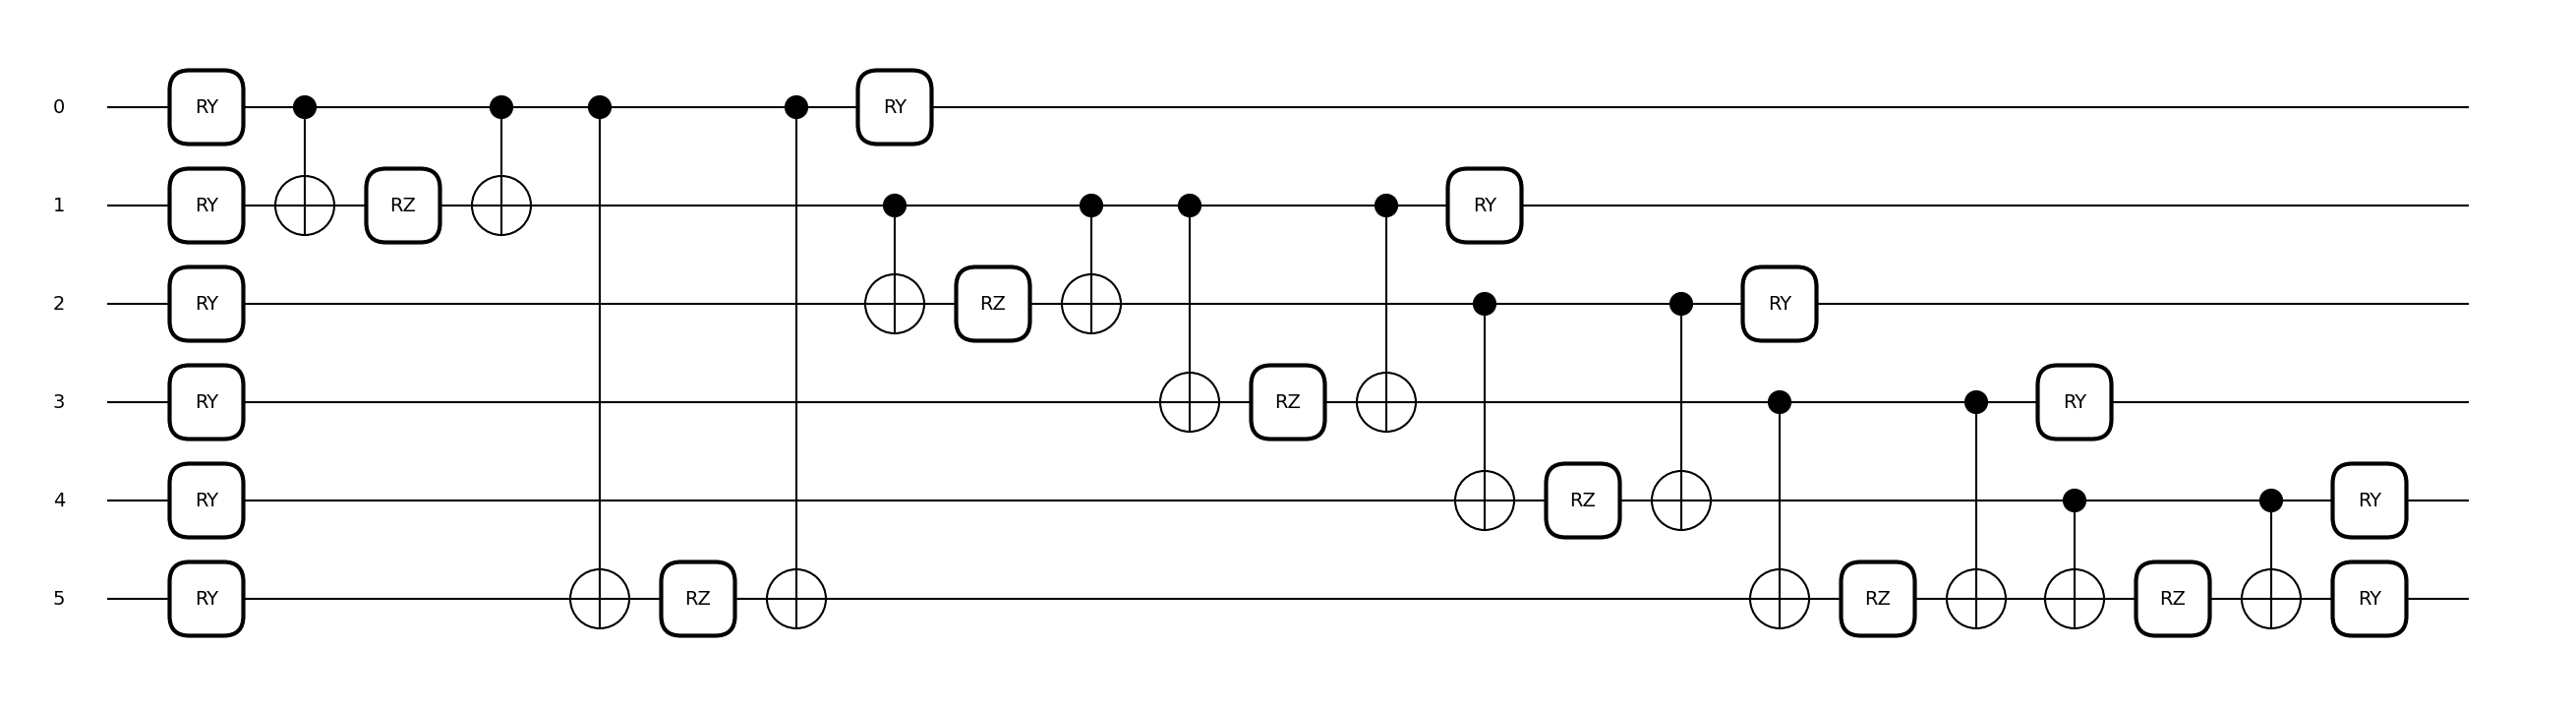

In [5]:
import pennylane as qml
from pennylane import numpy as np
import numpy as np_std
import matplotlib.pyplot as plt

# Set up a device with 6 qubits (one per node)
dev = qml.device("default.qubit", wires=6)

def generate_random_edges(num_nodes, edge_prob=0.5, seed=None):
    """
    Generate random undirected edges for a graph with num_nodes nodes.
    Each pair (i,j) is connected with probability edge_prob.
    """
    if seed is not None:
        np_std.random.seed(seed)
    edges = []
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np_std.random.rand() < edge_prob:
                edges.append((i, j))
    return edges

# Generate random edges for 6 nodes with a probability of 0.5
edges = generate_random_edges(num_nodes=6, edge_prob=0.5, seed=42)
print("Random edges:", edges)

@qml.qnode(dev)
def qgnn_circuit(features, crz_param, var_params, edges):
    """
    QGNN circuit for a graph with a given number of nodes.
    
    Args:
      features (array): Node features, one per node (length = num_nodes).
      crz_param (float): Parameter for the CRZ gates.
      var_params (array): Trainable parameters for the variational layer (length = num_nodes).
      edges (list of tuples): List of edges, where each tuple (i, j) indicates an edge between node i and node j.
    
    The circuit performs:
      1. Node feature encoding using RY rotations.
      2. Graph-structured entanglement by applying a CRZ gate for each edge.
      3. A variational update layer using trainable RY rotations.
    """
    num_nodes = len(features)
    
    # Step 1: Node Feature Encoding
    for i in range(num_nodes):
        qml.RY(features[i], wires=i)
    
    # Step 2: Graph-Structured Entanglement
    # For each edge (i, j), apply CRZ using CNOT - RZ - CNOT sequence.
    for (i, j) in edges:
        qml.CNOT(wires=[i, j])
        qml.RZ(crz_param, wires=j)
        qml.CNOT(wires=[i, j])
    
    # Step 3: Variational Update Layer
    for i in range(num_nodes):
        qml.RY(var_params[i], wires=i)
    
    return

# Example parameters
features = np.array([0.1, 0.5, 0.3, 0.6, 0.4, 0.8])
crz_param = 0.7
var_params = np.array([0.2, 0.4, 0.6, 0.3, 0.5, 0.7])

# Draw the circuit using matplotlib
fig = qml.draw_mpl(qgnn_circuit)(features, crz_param, var_params, edges)
plt.show()


Randomly generated edges: [(0, 1), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5), (4, 5)]


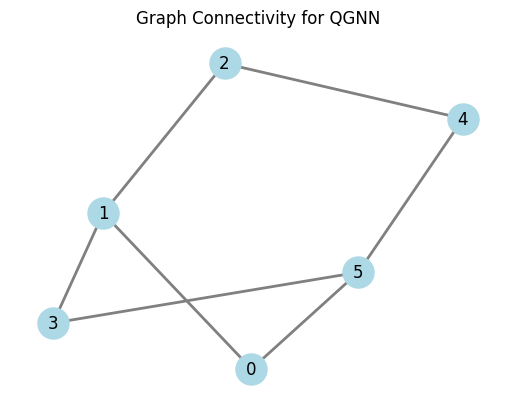

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def generate_random_edges(num_nodes=6, edge_prob=0.5, seed=42):
    """
    生成一個隨機無向圖的邊列表，
    每對節點 (i,j) 有 edge_prob 機率產生一條邊。
    """
    np.random.seed(seed)
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if np.random.rand() < edge_prob:
                edges.append((i, j))
    return edges

num_nodes = 6
edges = generate_random_edges(num_nodes=num_nodes, edge_prob=0.5, seed=42)
print("Randomly generated edges:", edges)

# Create a graph using NetworkX
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

# Draw the graph using a spring layout for a visually appealing arrangement
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title("Graph Connectivity for QGNN")
plt.axis('off')
plt.show()
